In [2]:
import nltk
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem.snowball import SnowballStemmer

from collections import defaultdict
from string import punctuation
from heapq import nlargest

%matplotlib inline

In [ ]:
# Inspiration/adapted from
# https://dl.acm.org/doi/10.1145/2133806.2133826
# https://app.pluralsight.com/library/courses/b0e30803-3df0-49e8-adb1-8ce0c27a28a3/table-of-contents
# http://brandonrose.org/clustering

This notebook is quite long, but here are the sections:
1. Basic data cleaning (removing stopwords, filtering, and stemming)
2. Fit 55 Clusters using KMeans on the UNSTEMMED dataset (basically creates garbage clusters like "al.-figure-2013")
3. Fit 10 Clusters using KMeans on the stemmed dataset (better named clusters!)
4. Compare 2-d projection of 10 clusters to Kaggle task point projections (cluster centroids look more spread out than Kaggle task)
5. Use K-NearestNeighbors to try to find 10 closest articles to Kaggle task descriptions, using both 797 dimensional space and 2 dimensional space (there's a clear problem with titles and more initial data cleaning is needed on the raw dataset)

In [3]:
comm_file_path = '../data/comm_use_subset/comm_use_subset'

In [8]:
dat = pd.read_csv("../data/all_sources_metadata_2020-03-13.csv")

In [4]:
stemmer = SnowballStemmer("english")

In [6]:
test_file = '../data/comm_use_subset/comm_use_subset/5e0c586f047ff909c8ed3fe171c8975a90608d08.json'

In [8]:
with open(test_file) as json_data:
    tmp = json.load(json_data)
    metadata = tmp['metadata']
#     paper_id = metadata['paper_id']
    title = metadata['title']
    body_text = tmp['body_text']
    full_text = ''
    for paragraph in body_text:
        full_text = full_text + paragraph['text'] + ' '

In [63]:
def getTextMetadata():
    title_list = []
    paper_id_list = []
    for root,dirs,files in os.walk(comm_file_path):
        for i, file in enumerate(files):
            with open(root+'/'+file) as json_data:
                tmp = json.load(json_data)
                metadata = tmp['metadata']
                title = metadata['title']
                if 'paper_id' in metadata.keys():
                    paper_id = metadata['paper_id']
                else:
                    paper_id = 'None'
                title_list.append(title)
                paper_id_list.append(paper_id)
    return title_list, paper_id_list

In [64]:
titles, paper_ids = getTextMetadata()

In [9]:
def getText():
    text_list = []
    for root,dirs,files in os.walk(comm_file_path):
        for i, file in enumerate(files):
            with open(root+'/'+file) as json_data:
                tmp = json.load(json_data)
                metadata = tmp['metadata']
                title = metadata['title']
                body_text = tmp['body_text']
                full_text = ''
                for paragraph in body_text:
                    full_text = full_text + paragraph['text'] + ' '
                text_list.append(full_text)
    return text_list

In [10]:
text_list = getText()

In [11]:
# Remove stopwords, special words, and punctuation

_stopwords = stopwords.words('english')

special_stopwords = ["abstract", "text", "abstracttext","introduction","background","method",
                                    "methods","methodology","conclusion","conclusions","objectives","results",
                                    "result","we","materials","purpose","significance","significant","mg","http","com",
                                    "author","copyright","funder","holder−preprin",
                                    "biorxiv", "copyright", "doi", "doi.org", "holder",
                                    "http","peer","preprint","review",
                                    "journal", "articl", "publi","includ", "studi"]
more_stopwords = ["et", "al", "article", "publish", "include", "studies"]
_stopwords = special_stopwords + more_stopwords + _stopwords

In [12]:
def remove_stopwords(text_list):
    no_stopword_text_list = [i for i in text_list if i not in _stopwords]
    return no_stopword_text_list
def remove_single_characters(text_list):
    no_singles = [i for i in text_list if len(i) > 1]
    return no_singles
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing only letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('^[a-zA-Z]', token):
            if token.isalpha() or token == 'covid-19':
                filtered_tokens.append(token)
    # filter out tokens that are stopwords
    filtered_tokens = remove_stopwords(filtered_tokens)
    # remove single characters
    filtered_tokens = remove_single_characters(filtered_tokens)
    
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return ' '.join(stems)

In [332]:
test = "this is a Lucky test 30% ha h 30mg covid-19 km089829.1"
tokenize_and_stem(test)

'lucki test ha covid-19'

In [334]:
stemmer.stem('genetic')

'genet'

In [335]:
stemmer.stem('genes')

'gene'

In [309]:
len(text_list)

9001

In [336]:
text_list[0][:100]

'Porcine epidemic diarrhea virus (PEDV), which belongs to the Alphacoronavirus genus of the Coronavir'

In [338]:
tokenize_and_stem(text_list[0][:100])

'porcin epidem diarrhea virus pedv belong alphacoronavirus genus coronavir'

In [13]:
stemmed_filtered_text_list = [tokenize_and_stem(i) for i in text_list]

In [36]:
vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.2,stop_words='english')

In [12]:
X = vectorizer.fit_transform(text_list)

In [37]:
X_stemmed = vectorizer.fit_transform(stemmed_filtered_text_list)

In [ ]:
# Fit 55 clusters to unstemmed text_list
kn = KMeans(n_clusters=55, max_iter = 50)
kn.fit(X)
# Check sizes of clusters
print(np.unique(kn.labels_, return_counts=True))
# Save results
pd.DataFrame(kn.labels_).to_csv('kn_labels_55.csv')
# Separate text list by cluster label
text = {}
for i, cluster in enumerate(kn.labels_):
    oneDocument = text_list[i]
    if cluster not in text.keys():
        text[cluster] = oneDocument
    else:
        text[cluster] += oneDocument

In [ ]:
# Separate text list by cluster label
text = {}
for i, cluster in enumerate(kn.labels_):
    oneDocument = text_list[i]
    if cluster not in text.keys():
        text[cluster] = oneDocument
    else:
        text[cluster] += oneDocument

In [346]:
# Get top 50 words in each cluster
keywords = {}
counts = {}
for cluster in range(55):
    word_sent = word_tokenize(text[cluster].lower())
    word_sent = [word for word in word_sent if word not in _stopwords]
    freq = FreqDist(word_sent)
    keywords[cluster] = nlargest(50, freq, key=freq.get)
    counts[cluster] = freq
# Get the top 3 unique-to-cluster words from the 50 top words
unique_keys={}
for cluster in range(55):
    other_clusters = list(set(range(10))-set([cluster]))
    keys_other_clusters = set(keywords[other_clusters[0]]).union(set(keywords[other_clusters[1]]))
    unique = set(keywords[cluster]) - keys_other_clusters
    unique_keys[cluster] = nlargest(3, unique, key=counts[cluster].get)
print(unique_keys[0], unique_keys[1])

['cells', 'fig', 'viral'] ['risk', 'disease', 'transmission']


In [347]:
svd = TruncatedSVD(n_components=2, n_iter=5, random_state=42)

In [183]:
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5, random_state=42,
             tol=0.0)

In [184]:
compressed = svd.transform(X)

In [185]:
x, y = compressed[0]

In [348]:
cluster_coords = {}
for i, cluster in enumerate(kn.labels_):
    x,y = compressed[i]
    if cluster not in cluster_coords.keys():
        cluster_coords[cluster] = [[x,y]]
    else:
        cluster_coords[cluster] = np.append(cluster_coords[cluster],[[x,y]],axis=0)
cluster_centroids = {}
for cluster in cluster_coords.keys():
    cluster_centroids[cluster] = cluster_coords[cluster].mean(axis=0)

In [350]:
# cluster_centroids

In [351]:
for i, text in enumerate(unique_keys.values()):
    print('-'.join(text))

cells-fig-viral
risk-disease-transmission
---figure-=
patients-=-p
cellular-figure-antiviral
china-chinese-malaria
compounds-drug-effects
vaccine-vaccines-dna
antibodies-binding-mabs
mice-+-figure
public-'s-global
models-0-r
samples-sequences-sequence
al.-figure-2013
mm-sequence-residues
figure-activation-gene
assay-samples-detection
lung-mice-patients
sequences-sequence-codon
strains-strain-pedv
figure-antiviral-50
patient-patients-hospital
influenza-pandemic-respiratory
=-participants-table
genome-sequence-genomes
infectious-pathogens-public
immune-response-activation
figure-identified-n
hiv-1-hiv-figure
s1-ibv-figure
binding-residues-structure
research-'-information
children-respiratory-patients
case-r-outbreak
respiratory-patients-infections
samples-serum-elisa
mice-vaccine-responses
species-bats-bat
contact-contacts-age
figure-synthesis-mm
public-outbreak-information
genes-gene-response
group-groups-p
influenza-figure-samples
group-pigs-day
figure-+-b
sars-cov-sars-patients
survei

Text(0.5, 1.0, 'Covid-19 articles in 55 clusters by KMeans and represented in 2D Space by Truncated SVD')

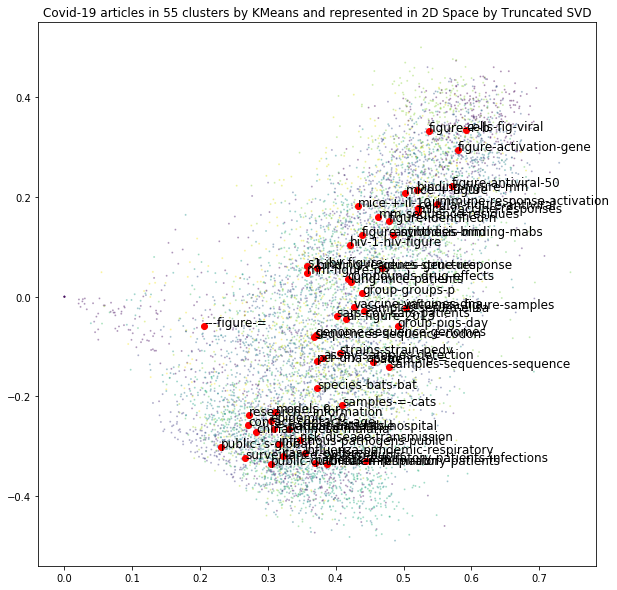

In [352]:
plt.figure(figsize=(10,10))
plt.scatter(compressed.T[0],compressed.T[1], c=kn.labels_, s=1, alpha=.3)
for cluster in cluster_centroids.keys():
    plt.scatter(cluster_centroids[cluster][0],cluster_centroids[cluster][1], c='red', linewidths=1)
for i, text in enumerate(unique_keys.values()):
    txt = '-'.join(text)
    plt.annotate(txt, (cluster_centroids[i][0], cluster_centroids[i][1]),size=12)
plt.title('Covid-19 articles in 55 clusters by KMeans and represented in 2D Space by Truncated SVD')

In [16]:
# Fit 10 clusters to stemmed text_list
kn_10 = KMeans(n_clusters=10, max_iter = 50)
kn_10.fit(X_stemmed)
# Check sizes of clusters
print(np.unique(kn_10.labels_, return_counts=True))
# Save results
pd.DataFrame(kn_10.labels_).to_csv('kn_labels_10_stemmed.csv')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([ 452,  529,  907, 1467, 1261,  997, 1022, 1212,  368,  786]))


In [17]:
# Separate text list by cluster label
text = {}
for i, cluster in enumerate(kn_10.labels_):
    oneDocument = stemmed_filtered_text_list[i]
    if cluster not in text.keys():
        text[cluster] = oneDocument
    else:
        text[cluster] += oneDocument

In [18]:
# Get top 50 words in each cluster
keywords = {}
counts = {}
for cluster in range(10):
    word_sent = word_tokenize(text[cluster].lower())
    word_sent = [word for word in word_sent if word not in _stopwords]
    freq = FreqDist(word_sent)
    keywords[cluster] = nlargest(50, freq, key=freq.get)
    counts[cluster] = freq
# Get the top 3 unique-to-cluster words from the 50 top words
unique_keys={}
for cluster in range(10):
    other_clusters = list(set(range(10))-set([cluster]))
    keys_other_clusters = set(keywords[other_clusters[0]]).union(set(keywords[other_clusters[1]]))
    unique = set(keywords[cluster]) - keys_other_clusters
    unique_keys[cluster] = nlargest(3, unique, key=counts[cluster].get)
print(unique_keys[0], unique_keys[1])

['vaccin', 'protect', 'antigen'] ['lung', 'observ', 'model']


In [19]:
svd = TruncatedSVD(n_components=2, n_iter=5, random_state=42)
svd.fit(X_stemmed)
compressed = svd.transform(X_stemmed)
cluster_coords = {}
for i, cluster in enumerate(kn_10.labels_):
    x,y = compressed[i]
    if cluster not in cluster_coords.keys():
        cluster_coords[cluster] = [[x,y]]
    else:
        cluster_coords[cluster] = np.append(cluster_coords[cluster],[[x,y]],axis=0)
cluster_centroids = {}
for cluster in cluster_coords.keys():
    cluster_centroids[cluster] = cluster_coords[cluster].mean(axis=0)

for i, text in enumerate(unique_keys.values()):
    print('-'.join(text))

vaccin-protect-antigen
lung-observ-model
sequenc-genom-sampl
inhibit-replic-rna
bind-structur-rna
sampl-assay-posit
patient-respiratori-case
case-number-time
transcript-analysi-sequenc
health-public-countri


Text(0.5, 1.0, 'Covid-19 articles in 10 clusters by KMeans and represented in 2D Space by Truncated SVD')

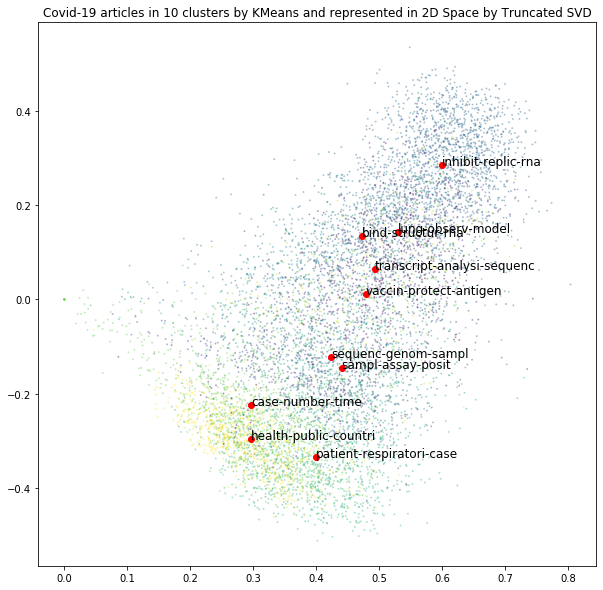

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(compressed.T[0],compressed.T[1], c=kn_10.labels_, s=1, alpha=.3)
for cluster in cluster_centroids.keys():
    plt.scatter(cluster_centroids[cluster][0],cluster_centroids[cluster][1], c='red', linewidths=1)
for i, text in enumerate(unique_keys.values()):
    txt = '-'.join(text)
    plt.annotate(txt, (cluster_centroids[i][0], cluster_centroids[i][1]),size=12)
plt.title('Covid-19 articles in 10 clusters by KMeans and represented in 2D Space by Truncated SVD')

In [28]:
X_stemmed

<9001x797 sparse matrix of type '<class 'numpy.float64'>'
	with 2828815 stored elements in Compressed Sparse Row format>

In [27]:
# Try to create TFIDF vector for Kaggle Tasks, find K closest papers, plot in 2-D space

In [25]:
kaggle_tasks = pd.read_csv('../Kaggle Task Clusters.csv')

In [26]:
kaggle_tasks.head()

,Task Title,Task Cluster Name,Task Description Text
0,"What is known about transmission, incubation, ...","Transmission, incubation, and environmental st...","What is known about transmission, incubation, ..."
1,What do we know about COVID-19 risk factors?,COVID-19 risk factors,What do we know about COVID-19 risk factors? W...
2,"What do we know about virus genetics, origin, ...","Virus genetics, origin, and evolution","What do we know about virus genetics, origin, ..."
3,What do we know about vaccines and therapeutics?,Vaccines and therapeutics,What do we know about vaccines and therapeutic...
4,What has been published about medical care?,Medical care,What has been published about medical care? Wh...


In [33]:
task_descriptions = []
for description in kaggle_tasks['Task Description Text']:
    clean_desc = tokenize_and_stem(description)
    task_descriptions.append(clean_desc)

In [40]:
task_tfidf = vectorizer.transform(task_descriptions)

In [42]:
kaggle_task_coords = svd.transform(task_tfidf)

Text(0.5, 1.0, 'Covid-19 articles in 10 clusters by KMeans and represented in 2D Space by Truncated SVD')

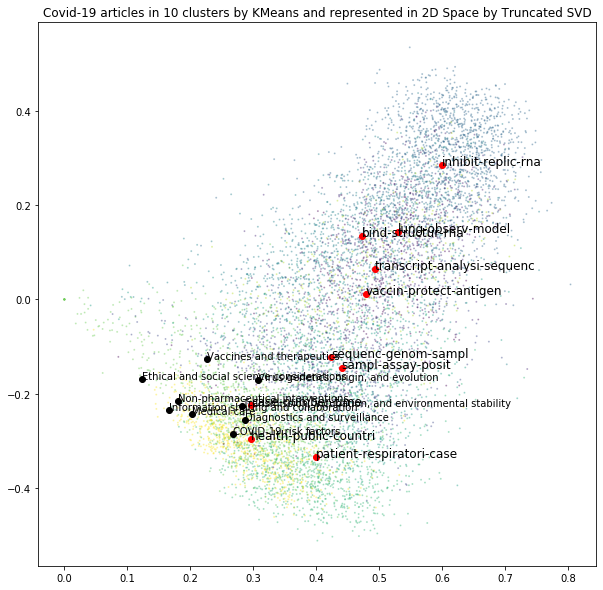

In [49]:
plt.figure(figsize=(10,10))
plt.scatter(compressed.T[0],compressed.T[1], c=kn_10.labels_, s=1, alpha=.3)
for cluster in cluster_centroids.keys():
    plt.scatter(cluster_centroids[cluster][0],cluster_centroids[cluster][1], c='red', linewidths=1)
for i, text in enumerate(unique_keys.values()):
    txt = '-'.join(text)
    plt.annotate(txt, (cluster_centroids[i][0], cluster_centroids[i][1]),size=12)
for task_point in kaggle_task_coords:
    plt.scatter(task_point[0],task_point[1], c='black', linewidths=1)
for k, name in enumerate(kaggle_tasks['Task Cluster Name']):
    plt.annotate(name, (kaggle_task_coords[k][0], kaggle_task_coords[k][1]))

plt.title('Covid-19 articles in 10 clusters by KMeans and represented in 2D Space by Truncated SVD')

In [50]:
task_tfidf

<9x797 sparse matrix of type '<class 'numpy.float64'>'
	with 606 stored elements in Compressed Sparse Row format>

In [52]:
X_stemmed

<9001x797 sparse matrix of type '<class 'numpy.float64'>'
	with 2828815 stored elements in Compressed Sparse Row format>

In [51]:
from sklearn.neighbors import NearestNeighbors

In [54]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(X_stemmed)

In [55]:
dist, ind = nbrs.kneighbors(X=task_tfidf)

In [59]:
dist

array([[0.97506293, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.8830442 , 0.88445752, 0.90511979, 0.9183662 , 0.9277022 ,
        0.92835684, 0.93292073, 0.94280975, 0.94946506, 0.95795923],
       [0.95219374, 0.97806571, 0.97973435, 0.99781591, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.95251049, 0.96356322, 0.97903348, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.97925272, 1.        , 1.       

It looks like even the "closest" points are nearly or exactly "1" away from our target points. This is probably because of the high dimesional space... Things tend to get further and further apart in the hypercube (to a maximum of 1, I think because that's the max value in our tfidf vectorized format of the docs)

In [69]:
ind

array([[1432, 3532, 1759, 2674, 8242, 4188, 4039, 7682, 2175, 8223],
       [4188, 4039, 3131, 8000, 1759, 8242, 8223, 3532, 2674, 7682],
       [1759, 5404, 4039, 8242, 8223, 7682, 3131, 4188, 2674, 3532],
       [6507, 6753, 7678, 8685,  792, 8668, 7700, 5066, 2923, 1445],
       [5094,  933, 1958, 3956, 8223, 8242, 2175, 7682, 3131, 3532],
       [4039, 2175, 5404, 8223, 7911, 8242, 4188, 2674, 7682, 3131],
       [2520, 8950, 1552, 3532, 2175, 7682, 8000, 5404, 4188, 2674],
       [8767, 8000, 3131, 4039, 1759, 3532, 7911, 5404, 7682, 8242],
       [2192, 3520,  934, 6117, 6124, 8211, 1537, 5453, 3951, 7410]])

In [68]:
for index, title in enumerate(kaggle_tasks['Task Title']):
    print("Looking for closest articles to: ", title)
    for n, i in enumerate(ind[index]):
        print(n, titles[i])
    print('______')

Looking for closest articles to:  What is known about transmission, incubation, and environmental stability?
0 Detecting Differential Transmissibilities That Affect the Size of Self-Limited Outbreaks
1 Thank you to Virology Journal's peer reviewers in 2013
2 한국의 첫번째 MERS-CoV 유행의 역학적 특징: 평택 성모 병원을 중 심으로
3 
4 VENN gene lists resistant versus control for CC strains
5 
6 Origin, Genetic Diversity, and Evolutionary Dynamics of Novel Porcine Circovirus 3
7 
8 제주도 쯔쯔가무시증의 역학적 특성 Epidemiologic characteristics of scrub typhus in Jeju Island
9 감염병 대응인력 대상 설문조사를 통한 역학조사교육의 개편방향 건양대학교 의과대학 예방의학교실, 동국대학교 의과대학 예방의학교실 * The Direction of Restructuring of Korea Field Epidemiology Training Program through Questionnaire Survey among Communicable Disease Response Staff in Korea Division of Public Health Preparedness and Response, Centers for Disease Control and Prevention, Republic of Korea ** Running Title : Restructuring of a Korea Field Epidemiology Training Program
______
Looking for closest articles 

In [70]:
nbrs_compressed = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(compressed)

In [72]:
dist, ind = nbrs_compressed.kneighbors(X=kaggle_task_coords)

In [74]:
dist

array([[0.00180387, 0.00226568, 0.00372101, 0.00498957, 0.00520249,
        0.00585505, 0.00594541, 0.0061553 , 0.00755933, 0.007818  ],
       [0.00061324, 0.00304487, 0.0036506 , 0.00393259, 0.00451898,
        0.00489152, 0.00531184, 0.00582351, 0.00621427, 0.00643316],
       [0.00572089, 0.0063779 , 0.00736668, 0.00809701, 0.00872069,
        0.00948793, 0.01076544, 0.01123221, 0.01235239, 0.01288346],
       [0.00408692, 0.00703162, 0.00703162, 0.01225138, 0.01239414,
        0.01358785, 0.01484745, 0.01533029, 0.01598155, 0.01604214],
       [0.00065088, 0.00430076, 0.00515503, 0.00814291, 0.00876331,
        0.00885989, 0.00991704, 0.01026786, 0.01061015, 0.01125937],
       [0.00459972, 0.00544804, 0.00583012, 0.00852987, 0.00894212,
        0.00975884, 0.01019066, 0.01197205, 0.01275387, 0.01387604],
       [0.00297563, 0.00346136, 0.00387126, 0.00516332, 0.00518362,
        0.00533081, 0.00576873, 0.00616058, 0.00687945, 0.00748056],
       [0.00907249, 0.01649749, 0.0217627

In [73]:
for index, title in enumerate(kaggle_tasks['Task Title']):
    print("Looking for closest articles to: ", title)
    for n, i in enumerate(ind[index]):
        print(n, titles[i])
    print('______')

Looking for closest articles to:  What is known about transmission, incubation, and environmental stability?
0 Originalien und Übersichten Disinfection of aircraft Appropriate disinfectants and standard operating procedures for highly infectious diseases
1 Article 139 Herds Based on Surveillance Data
2 OPEN ACCESS
3 A Statistical Framework for the Adaptive Management of Epidemiological Interventions
4 Prolonging herd immunity to cholera via vaccination: Accounting for human mobility and waning vaccine effects
5 Trends in North American Newspaper Reporting of Brain Injury in Ice Hockey
6 China's shifting neglected parasitic infections in an era of economic reform, urbanization, disease control, and the Belt and Road Initiative
7 A Likelihood Approach for Real-Time Calibration of Stochastic Compartmental Epidemic Models
8 Advantages and Limitations of Anticipating Laboratory Test Results from Regression-and Tree-Based Rules Derived from Electronic Health-Record Data
9 Normal Thoracic Rad